In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, Input
from keras.losses import CategoricalCrossentropy 
import sys

def column_one_hot (dataframe, columns): 
    for column in columns:
        if column in dataframe:
            one_hot = pd.get_dummies(dataframe[column])
            dataframe = dataframe.drop(column,axis = 1)
            dataframe = pd.concat([dataframe, one_hot], axis=1)
    return dataframe

def drop_columns (dataframe, columns):
    for column in columns:
        if column in dataframe.columns:
            dataframe = dataframe.drop(column, axis=1)
    return dataframe

def drop_column (dataframe, column):
    if column in dataframe.columns:
        dataframe = dataframe.drop(column, axis=1)
    return dataframe

In [13]:
df = pd.read_csv('SAR_Data.csv')
df.shape

(14572, 6)

In [14]:
status = df['Status'].unique()
for x in status:
    print(x + " " + str(len(df[df['Status'] == x])))

print ("----------------------------------------------------------------")

maskOpen = ((df['Status'] == 'postponed') | (df['Status'] == 'partly open') |( df['Status'] == 'In creation'))
maskClosed = (df['Status'] == 'partly closed')
df.loc[maskOpen, 'Status'] = 'open'
df.loc[maskClosed, 'Status'] = 'closed'
df.loc[(df['Status'] == 'non applicable'), 'Status'] = 'not applicable'
status = df['Status'].unique()
for x in status:
    print(x + " " + str(len(df[df['Status'] == x])))

# postponed, partly open, in creation -> open;    partly closed -> closed

In creation 773
non applicable 4052
closed 6772
forwarded 1339
open 111
postponed 12
compliant 1413
partly closed 92
partly open 8
----------------------------------------------------------------
open 904
not applicable 4052
closed 6864
forwarded 1339
compliant 1413


([<matplotlib.patches.Wedge at 0x25b8812cc70>,
 [Text(1.0791749596761293, 0.2130291210328414, 'open'),
  Text(0.33287410392687333, 1.0484249286119065, 'not applicable'),
  Text(-0.978140167763154, -0.5032313704532628, 'closed'),
  Text(0.6855473250388082, -0.8602469791473464, 'forwarded'),
  Text(1.049353730597924, -0.32993446027994694, 'compliant')],
 [Text(0.5886408870960704, 0.11619770238154983, '6.2%'),
  Text(0.1815676930510218, 0.5718681428792216, '27.8%'),
  Text(-0.533531000598084, -0.2744898384290524, '47.1%'),
  Text(0.3739349045666226, -0.46922562498946163, '9.2%'),
  Text(0.5723747621443221, -0.1799642510617892, '9.7%')])

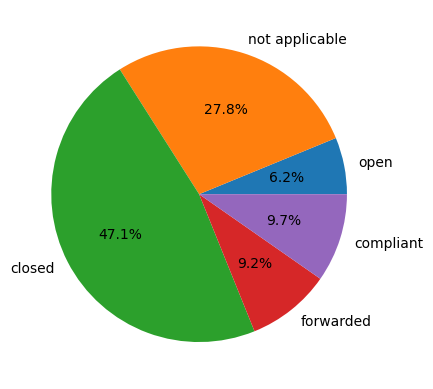

In [17]:
status = df['Status'].unique()
hauefigkeit = []
for x in status:
    hauefigkeit.append(len(df[df['Status'] == x]))
fig, ax = plt.subplots()
ax.pie(hauefigkeit, labels=status, autopct='%1.1f%%')

In [20]:
print(df['Version'].unique())

['DCM' 'ACM300' 'Trainguard 200 RBC' 'SICAS ECC' 'SIMIS IS'
 'ETCS Engineering Process' 'CG ETCS Workstation' 'AzS350U' 'TGMT'
 'ACM200' 'Clearguard TCM 100' 'VICOS OC111' 'LED_70_at_Som6'
 'LED_Anzeigemodul' 'LEU S21 MS MC MT 208-233_-433_-533'
 'Eurobalise S21 und S22' 'SIMIS W' 'VICOS NCU' 'LED_70' 'LED_136'
 'POM4 S700K BSG9' 'Key Switch' 'VICOS OC501' 'LZB700M' nan
 'LEU S21 MS MC MT 208-203_-403_-503' 'Eurobalise S21' '/' 'DTS'
 'SIMIS LC' 'AC100' 'LEU S21 M ME 208-201_-401']


In [15]:
# falsche Ordnerstruktur in /RA Application Conditions/03_PG_OCS/Service and diagnostic systems
# fehlt ein Ordner bevor Module kommen, deshalb händisch eintragen

dfVersion = df.loc[df['Version'].str.contains('VICOS_S_D')][['Product','Version']]
dfVersion['Version'] = dfVersion['Version'].str[-5:]
df.loc[df['Version'].str.contains('VICOS_S_D'), 'Product'] = 'VICOS_S_D'
df.loc[df['Version'].str.contains('VICOS_S_D'), 'Version'] = dfVersion['Version']

In [16]:
paths = df['Path'].unique()
accessDB = pd.read_xml("X:/File/DE/bwga024a_IMORA_RM/05_Process_Management/14_Metriken & KPI/KPI-Erhebung/KPI_01-04_General/Data/Input/Input_BWG_Combined_Access.xml")

for path in paths:
    try:
        if(path == "/ML Realization Projects Algeria"):
            result = accessDB.loc[(accessDB['Type'] == "Real") & (accessDB['Location'] == "BWG") & (accessDB['Offset'] == "/ML Realization Projects Algeria/20006_ML_BM_Boughezoul_MSila")].iloc[0]
        else:
            result = accessDB.loc[(accessDB['Type'] == "Real") & (accessDB['Location'] == "BWG") & ((accessDB['Offset'] == str(path)) | (accessDB['Offset'] == (str(path) + "/")))].iloc[0]           
    except:
        print(str(path) + " has no entry in the AccessDB!")

    mask = df['Path'] == str(path)
    df.loc[mask, 'Project_category'] = result['Project_category']
    df.loc[mask, 'BS'] = result['BS']
    df.loc[mask, 'RU'] = result['RU']
    df.loc[mask, 'ProjectYear'] = result['ProjectYear']
    df.loc[mask, 'section'] = result['section']
    df.loc[mask, 'Project_name'] = result['Project_name']
    df['ProductVersion'] = df["Product"].str.cat(df["Version"], sep = "-")

df['ProjectYear'] = df['ProjectYear'].astype('int')
df = df[['Text', 'Product', 'ProductVersion', 'Path', 'Project_name', 'section', 'Project_category', 'BS', 'RU', 'ProjectYear', 'Status', 'Statement']]
#df = drop_column(df, 'Statement') # später wieder löschen!
df.head()


,Text,Product,ProductVersion,Path,Project_name,section,Project_category,BS,RU,ProjectYear,Status,Statement
0,The equipment described may only be used with...,DCM,DCM-DCM 300,/54742-NO-MM-NO-MM-ML-ERTMS Trackside,NO Bane Norway TRA,BS MainLine,A,ML,HQ,2018,In creation,TERMINATE Maintenance DCM 300 A6Z00050460843...
1,Equalize the charge before inserting the xCM....,DCM,DCM-DCM 300,/54742-NO-MM-NO-MM-ML-ERTMS Trackside,NO Bane Norway TRA,BS MainLine,A,ML,HQ,2018,In creation,TERMINATE Maintenance DCM 300 A6Z00050460843...
2,In order to avoid unnecessary aging of the spa...,DCM,DCM-DCM 300,/54742-NO-MM-NO-MM-ML-ERTMS Trackside,NO Bane Norway TRA,BS MainLine,A,ML,HQ,2018,In creation,TERMINATE Maintenance DCM 300 A6Z00050460843...
3,The DCM must be mounted on a mounting unit. If...,DCM,DCM-DCM 300,/54742-NO-MM-NO-MM-ML-ERTMS Trackside,NO Bane Norway TRA,BS MainLine,A,ML,HQ,2018,In creation,TERMINATE Covered by [REF PAC_DigIO_2980]
4,Dispose of faulty electronic circuit boards r...,DCM,DCM-DCM 300,/54742-NO-MM-NO-MM-ML-ERTMS Trackside,NO Bane Norway TRA,BS MainLine,A,ML,HQ,2018,In creation,TERMINATE Maintenance DCM 300 A6Z00050460843...


In [17]:
text = df['Text'].value_counts()
eins = 0
for anzahl in text:
    if anzahl == 1:
        eins += 1
print ("Anzahl Anwendungsregeln, welche nur einmal bewertet wurden: " + str(eins))
print ("Anteil am Datensatz: " + str(round(round(eins/df.shape[0], 4) * 100, 2)) + "%")
    
#text.head(10)
test = df.loc[df['Text'] == "Zur Anschaltung des Antriebes in der Außenanlage müssen Signalkabel nach VDE 0816/2 oder Kabel mit vergleichbaren Eigenschaften verwendet werden. Die Verlegevorschriften des Kabels sind einzuhalten."]
test.reset_index(inplace=True, drop=True)
test.head(17)

Anzahl Anwendungsregeln, welche nur einmal bewertet wurden: 4198
Anteil am Datensatz: 28.81%


,Text,Product,ProductVersion,Path,Project_name,section,Project_category,BS,RU,ProjectYear,Status,Statement
0,Zur Anschaltung des Antriebes in der Außenanla...,SICAS ECC,SICAS ECC-W20,/1809_Incheon_Songdo,KR Incheon Songdo,BS MassTransit,C,MT,HQ,2018,non applicable,DC_POM modules are not used in the SDO7 projec...
1,Zur Anschaltung des Antriebes in der Außenanla...,SICAS ECC,SICAS ECC-S23_1,/1401_Istanbul_L4,TR Istanbul L4,BS MassTransit,C,MT,HQ,2014,non applicable,Für das Projekt Istanbul Metro Linie 1 und 4 n...
2,Zur Anschaltung des Antriebes in der Außenanla...,SICAS ECC,SICAS ECC-W20,/1104_Chennai_Metro_Phase,IN Chennai,BS MassTransit,B,MT,HQ,2011,closed,During the commissioning the rule will be che...
3,Zur Anschaltung des Antriebes in der Außenanla...,SICAS ECC,SICAS ECC-W20,/1104_Chennai_Metro_Phase,IN Chennai,BS MassTransit,B,MT,HQ,2011,non applicable,According to the circuit diagrams STG A6Z0004...
4,Zur Anschaltung des Antriebes in der Außenanla...,SICAS ECC,SICAS ECC-W16,/1401_Istanbul_L4,TR Istanbul L4,BS MassTransit,C,MT,HQ,2014,closed,Es wurden Signalkabel nach VDE0816/2 bzw. mit ...
5,Zur Anschaltung des Antriebes in der Außenanla...,SICAS ECC,SICAS ECC-W16,/1401_Istanbul_L4,TR Istanbul L4,BS MassTransit,C,MT,HQ,2014,non applicable,Dieses Requirement ist für das Projekt Istanbu...
6,Zur Anschaltung des Antriebes in der Außenanla...,SICAS ECC,SICAS ECC-W18_1,/1203_BuenosAires_Line_H_Extension,AR Buenos Aires Line H,BS MassTransit,C,MT,HQ,2012,compliant,Zur Anschaltung der Weichen in der Außenanlage...
7,Zur Anschaltung des Antriebes in der Außenanla...,SICAS ECC,SICAS ECC-W18_1,/1203_BuenosAires_Line_H_Extension,AR Buenos Aires Line H,BS MassTransit,C,MT,HQ,2012,compliant,In diesem Projekt wird die DC-POM nicht einges...
8,Zur Anschaltung des Antriebes in der Außenanla...,SICAS ECC,SICAS ECC-S29,/1203_BuenosAires_Line_H_Extension,AR Buenos Aires Line H,BS MassTransit,C,MT,HQ,2012,compliant,Im Projekt BALH sind die Signalkabel nach VDE...
9,Zur Anschaltung des Antriebes in der Außenanla...,SICAS ECC,SICAS ECC-Spemom 4.1,/1203_BuenosAires_Line_H_Extension,AR Buenos Aires Line H,BS MassTransit,C,MT,HQ,2012,compliant,Zur Anschaltung der Fahrsperren in der Außenan...


In [11]:
print(df['Product'].unique())
testdf = df[df['Product'] == "/"]
testdf.shape
# '/57022-ML-HU-Szazhalombatta-Pusztaszabolcs' hat keinen Link auf RA Application Conditions sondern nur zu einem Modul in einem anderen Projekt aus Ungarn
# '/55525_ML_HU_KLBA' hat teilweise keinen Link auf RA Application Conditions

## Hoffentlich gefixt, Update: nur teilweise gefixt, 147 Objekte immernoch keinen Link auf RA Application Conditions

['DCM' 'ACM300' 'Trainguard 200 RBC' 'SICAS ECC' 'SIMIS IS'
 'ETCS Engineering Process' 'CG ETCS Workstation' 'AzS350U' 'TGMT'
 'ACM200' 'Clearguard TCM 100' 'VICOS OC111' 'LED_70_at_Som6'
 'LED_Anzeigemodul' 'LEU S21 MS MC MT 208-233_-433_-533'
 'Eurobalise S21 und S22' 'SIMIS W' 'VICOS NCU' 'LED_70' 'LED_136'
 'POM4 S700K BSG9' 'Key Switch' 'VICOS OC501' 'LZB700M' 'VICOS_S_D'
 'LEU S21 MS MC MT 208-203_-403_-503' 'Eurobalise S21' '/' 'DTS'
 'SIMIS LC' 'AC100' 'LEU S21 M ME 208-201_-401']


(147, 12)

In [18]:
df_product = df[['Product']]
products = df_product['Product'].unique()
df_product = column_one_hot(df_product, ['Product'])
for path in paths:
    for product in products:
        df_product.loc[df['Path'] == path, product] = 1 if (df_product.loc[df['Path'] == path][product].sum()) >= 1 else 0
if (not (products[0] in df)):        
    df = df.join(df_product)
df = drop_column(df, 'Product')
df = drop_column(df, 'Path')
df = column_one_hot(df, ['ProductVersion', 'Project_name', 'section',
       'Project_category', 'BS', 'RU', 'ProjectYear'])
df.head()

,Text,Status,Statement,/,AC100,ACM200,ACM300,AzS350U,CG ETCS Workstation,Clearguard TCM 100,...,2009,2011,2012,2013,2014,2015,2017,2018,2019,2020
0,The equipment described may only be used with...,In creation,TERMINATE Maintenance DCM 300 A6Z00050460843...,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,Equalize the charge before inserting the xCM....,In creation,TERMINATE Maintenance DCM 300 A6Z00050460843...,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,In order to avoid unnecessary aging of the spa...,In creation,TERMINATE Maintenance DCM 300 A6Z00050460843...,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,The DCM must be mounted on a mounting unit. If...,In creation,TERMINATE Covered by [REF PAC_DigIO_2980],0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Dispose of faulty electronic circuit boards r...,In creation,TERMINATE Maintenance DCM 300 A6Z00050460843...,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [19]:
df_training = df
text = "Zur Anschaltung des Antriebes in der Außenanlage müssen Signalkabel nach VDE 0816/2 oder Kabel mit vergleichbaren Eigenschaften verwendet werden. Die Verlegevorschriften des Kabels sind einzuhalten."
df_training = df_training.loc[df_training['Text'] == text]
df_training.reset_index(inplace=True, drop=True)

test_col = 12
test = drop_columns(df_training.iloc[[test_col]], ['Text', 'Status', 'Statement'])
df_training = df_training.drop(test_col)

In [20]:
trainX = drop_columns(df_training, ['Status', 'Text', 'Statement'])
trainYStatus = drop_column(column_one_hot(df_training[['Text', 'Status']], ['Status']), "Text")
trainYStatement = drop_column(column_one_hot(df_training[['Text', 'Statement']], ['Statement']), "Text")

In [23]:
modelStatus = Sequential()
modelStatus.add(Input(shape=trainX.shape[1]))
modelStatus.add(Dense(16, activation='relu'))
modelStatus.add(Dense(trainYStatus.shape[1], activation='softmax'))
modelStatus.summary()
modelStatus.compile(optimizer='adam',
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

history = modelStatus.fit(trainX, trainYStatus,
                    batch_size=2,
                    epochs=50,
                    verbose=2,
                    validation_split=0.4)

modelStatement = Sequential()
modelStatement.add(Input(shape=trainX.shape[1]))
modelStatement.add(Dense(16, activation='relu'))
modelStatement.add(Dense(trainYStatement.shape[1], activation='softmax'))
modelStatement.summary()
modelStatement.compile(optimizer='adam',
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

history = modelStatement.fit(trainX, trainYStatement,
                    batch_size=2,
                    epochs=50,
                    verbose=2,
                    validation_split=0.4)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 8)                 1424      
                                                                 
 dense_5 (Dense)             (None, 3)                 27        
                                                                 
Total params: 1,451
Trainable params: 1,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5/5 - 1s - loss: 1.2488 - accuracy: 0.2222 - val_loss: 1.1915 - val_accuracy: 0.0000e+00 - 1s/epoch - 215ms/step
Epoch 2/50
5/5 - 0s - loss: 1.2254 - accuracy: 0.2222 - val_loss: 1.1866 - val_accuracy: 0.0000e+00 - 57ms/epoch - 11ms/step
Epoch 3/50
5/5 - 0s - loss: 1.2075 - accuracy: 0.2222 - val_loss: 1.1848 - val_accuracy: 0.0000e+00 - 67ms/epoch - 13ms/step
Epoch 4/50
5/5 - 0s - loss: 1.1963 - accuracy: 0.3333 - val_loss: 1.1790 -

In [ ]:
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()

In [24]:
predictionStatus = modelStatus.predict(test)
col = 0
for i in predictionStatus:
    for j in i:
        print (trainYStatus.columns[col] + " " + '{:.1%}'.format(j))
        col += 1

print ("-----------------------------------------------------")

predictionStatement = modelStatement.predict(test)
index_max = np.argmax(predictionStatement)
print (trainYStatement.columns[index_max] + " " + '{:.1%}'.format(predictionStatement[0][index_max]))
#col = 0
#for i in predictionStatement:
#    for j in i:
#        print (trainYStatement.columns[col] + " " + '{:.1%}'.format(j))
#        col += 1
#

1/1 [==============================] - 0s 67ms/step
closed 33.6%
compliant 18.8%
non applicable 47.6%
-----------------------------------------------------
1/1 [==============================] - 0s 202ms/step
Für das Projekt Istanbul Metro Linie 1 und 4 nicht relevant  da keine TOM im Einsatz ist. 13.5%
